In [1]:
import pandas as pd
import numpy as np
import boto3
from pathlib import Path
import glob
import re
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from LFP_util import data_manage as dm
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

from scripts.init import *

%load_ext autoreload
%autoreload 2

## Evaluate CNN predictions

In [2]:
# Get CNN prediction

client = get_s3_client()
for animal in ANIMALS_DATASET:
    preds = get_predictions(animal, client)
    for ind, pred in enumerate(preds):
        if os.path.exists(f'./data/CNN_Pred/{animal}_run{ind}.csv.zip'): continue
        print(f'Getting file {pred}')
        client.download_file('hengenlab', pred, f'./data/CNN_Pred/{animal}_run{ind}.csv.zip')

data = pd.DataFrame(dict(Animal=ANIMALS_DATASET))

In [3]:
wake_acc = []
nrem_acc = []
rem_acc = []

acc = [wake_acc, nrem_acc, rem_acc]
for i, animal in enumerate(ANIMALS):
    print(f"Reading {animal}")
    selection_animal = pd.concat(
        [pd.read_csv(f) for f in glob.glob(f'./data/CNN_Pred/*{animal}*')]
    )
    for j in range(3):
        selection = selection_animal[selection_animal['label_wnr_012'] == j]
        acc[j].append((selection['label_wnr_012'] == selection['predicted_wnr_012']).mean())

Reading CAF37
Reading CAF78
Reading KDR14
Reading KDR27
Reading KDR36
Reading CAF26
Reading CAF34
Reading CAF42
Reading CAF69


In [4]:
data['Wake_acc'] = acc[0]
data['nrem_acc'] = acc[1]
data['rem_acc'] = acc[2]
data

,Animal,Wake_acc,nrem_acc,rem_acc
0,CAF37_day1,0.879370,0.912931,1.000000
1,CAF78_day1,0.933710,0.637066,0.683151
2,KDR14_day1,0.917279,0.865704,0.909080
3,KDR27_day1,0.823375,0.849993,0.891363
4,KDR36_day1,0.912533,0.858387,0.896295
5,CAF26,0.929287,0.864537,0.757407
6,CAF34,0.882978,0.852168,0.880673
7,CAF42,0.947259,0.732672,0.830645
8,CAF69,0.745957,0.785909,0.848233


In [5]:
label_arr = []
prediction_arr = []

for file in glob.glob('./data/CNN_Pred/*'):
    temp = pd.read_csv(file)
    if (temp['label_wnr_012'] == temp['predicted_wnr_012']).mean() < 0.8:
        continue
    label_arr.append(temp['label_wnr_012'])
    prediction_arr.append(temp['predicted_wnr_012'])

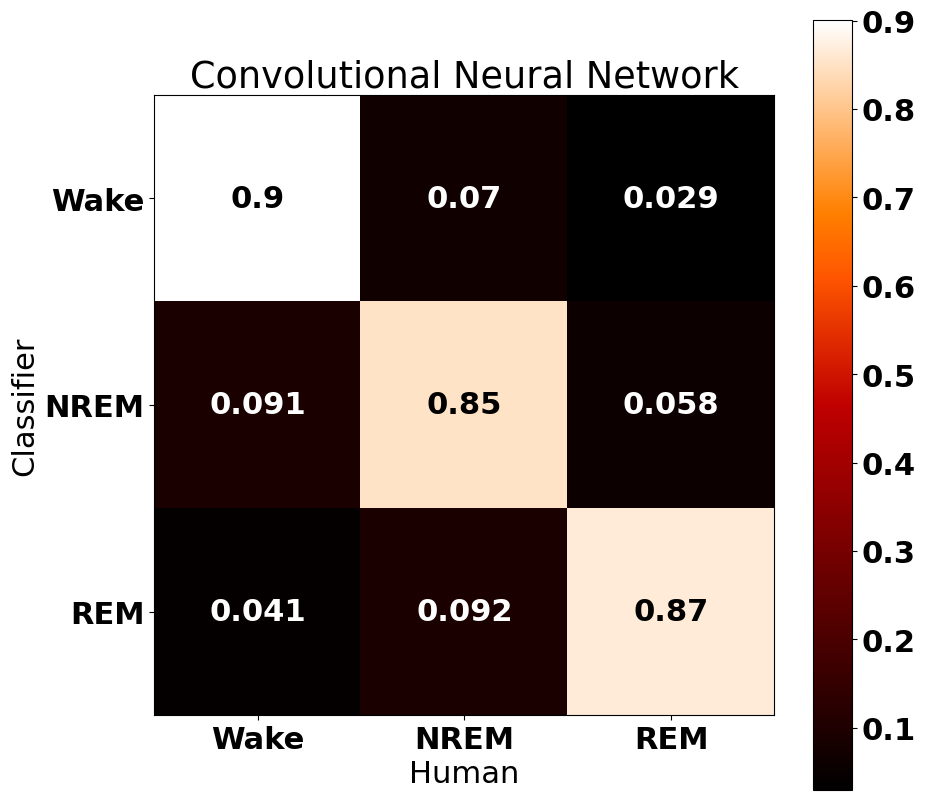

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

font = {
    'weight' : 'bold',
    'size'   : 22}
plt.rc('font', **font)

y_hat = np.concatenate(prediction_arr)
y_test = np.concatenate(label_arr)

fig, ax= plt.subplots(figsize=(10,10))
cm = confusion_matrix(y_test, y_hat)
cm2 = cm.copy().astype('float')
for row_id in range(cm.shape[0]):
    for col_id in range(cm.shape[1]):
        cm2[row_id, col_id] = cm[row_id, col_id] / cm[row_id].sum()
dis = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['Wake','NREM','REM'], )
dis.plot(cmap=plt.cm.gist_heat, ax=ax);
plt.gca().set_xlabel('Human')
plt.gca().set_ylabel('Classifier')
plt.title("Convolutional Neural Network")
plt.savefig('./data/CNN_acc.pdf', format='pdf')

In [11]:
# fig, axs = plt.subplots(len(ANIMALS),3,figsize=(8,15))
# for i, animal in enumerate(ANIMALS):
#     selection_animal = pd.concat(
#         [pd.read_csv(f) for f in glob.glob(f'./data/CNN_Pred/*{animal}*')]
#     )
#     for j in range(3):
#         selection = selection_animal[selection_animal['label_wnr_012'] == j]
#         axs[i,j].bar(
#             ['TP', 'TN'],
#             ((selection['label_wnr_012'] == selection['predicted_wnr_012']).mean(),
#             (selection['label_wnr_012'] != selection['predicted_wnr_012']).mean())
#         )
#         axs[i,j].set_ylim(0, 1)
#         axs[i,j].title.set_text(animal)

## Extract Flickers

The flicker files are extracted using scripts @Adian and @David ran on HPC. The results are saved with the "<Animal>/flicker-calling/Results/" prefix. The first step is to cache the flicker files specified by the model parameter "wnr-2-v14-24k" which are 1s models and by other parameters regarding the flicker extraction script.


In [12]:
# Download flicker files

client = get_s3_client()
for animal in ANIMALS_DATASET:
    preds = get_flickers(animal, client)
    for ind, pred in enumerate(preds):
        print(f'Getting file {pred}')
        client.download_file('hengenlab', pred, f'./data/Flicker_data/{animal}_run{ind}.csv.zip')

flicker_files = glob.glob(FLICKER_DIR + '*')

Getting file CAF37_day1/flicker-calling/Results/flicker-calling-narrownone-CAF37_day1-wnr-v14-perregion-c24k.csv.zip
Getting file CAF78_day1/flicker-calling/Results/flicker-calling-narrownone-CAF78_day1-wnr-v14-perregion-c24k.csv.zip
Getting file KDR14_day1/flicker-calling/Results/flicker-calling-narrownone-KDR14_day1-wnr-v14-perregion-c24k.csv.zip
Getting file KDR27_day1/flicker-calling/Results/flicker-calling-narrownone-KDR27_day1-wnr-v14-perregion-c24k.csv.zip
Getting file KDR36_day1/flicker-calling/Results/flicker-calling-narrownone-KDR36_day1-wnr-v14-perregion-c24k.csv.zip
Getting file CAF26/flicker-calling/Results/flicker-calling-narrownone-CAF26-wnr-v14-perregion-c24k.csv.zip
Getting file CAF34/flicker-calling/Results/flicker-calling-narrownone-CAF34-wnr-v14-perregion-c24k.csv.zip
Getting file CAF42/flicker-calling/Results/flicker-calling-narrownone-CAF42-wnr-v14-perregion-c24k.csv.zip
Getting file CAF69/flicker-calling/Results/flicker-calling-narrownone-CAF69-wnr-v14-perregion-

In [13]:
%pdb

Automatic pdb calling has been turned ON


## Statistics

In [14]:
all_bout_rates = stat_eval(compute_hour_rate_by_bout)
all_bout_rates = all_bout_rates[all_bout_rates.Rate != 0]
all_bout_rates.Rate = all_bout_rates.Rate / all_bout_rates.Bout_duration

Found channels: -0-64 in column: CA1-0-64-flicker-state
Found channels: -128-192 in column: CA1-128-192-flicker-state
Found channels: -192-256 in column: CA1-192-256-flicker-state
Found channels: -0-64 in column: CA1-0-64-flicker-state
Found channels: -0-64 in column: CA1-0-64-flicker-state
Found channels: -64-128 in column: CA1-64-128-flicker-state
Found channels: -0-64 in column: CA1-0-64-flicker-state
Found channels: -128-192 in column: CA1-128-192-flicker-state
Found channels: -0-64 in column: CA1-0-64-flicker-state


### Duration Computation

In [15]:
all_rates = stat_eval(compute_hour_rate)

Found channels: -0-64 in column: CA1-0-64-flicker-state
Found channels: -128-192 in column: CA1-128-192-flicker-state
Found channels: -192-256 in column: CA1-192-256-flicker-state
Found channels: -0-64 in column: CA1-0-64-flicker-state
Found channels: -0-64 in column: CA1-0-64-flicker-state
Found channels: -64-128 in column: CA1-64-128-flicker-state
Found channels: -0-64 in column: CA1-0-64-flicker-state
Found channels: -128-192 in column: CA1-128-192-flicker-state
Found channels: -0-64 in column: CA1-0-64-flicker-state


In [16]:
all_durations = stat_eval(compute_duration)

Found channels: -0-64 in column: CA1-0-64-flicker-state
Found channels: -128-192 in column: CA1-128-192-flicker-state
Found channels: -192-256 in column: CA1-192-256-flicker-state
Found channels: -0-64 in column: CA1-0-64-flicker-state
Found channels: -0-64 in column: CA1-0-64-flicker-state
Found channels: -64-128 in column: CA1-64-128-flicker-state
Found channels: -0-64 in column: CA1-0-64-flicker-state
Found channels: -128-192 in column: CA1-128-192-flicker-state
Found channels: -0-64 in column: CA1-0-64-flicker-state


## Visualization
Add genotype to the dataframe for visualization

In [17]:
all_rates_geno = all_rates.set_index('Animal').join(dm.agg('Animal')['Genotype'])
all_durations_geno = all_durations.set_index('Animal').join(dm.agg('Animal')['Genotype'])
all_bout_rates_geno = all_bout_rates.set_index('Animal').join(dm.agg('Animal')['Genotype'])

In [18]:
# Based on a strong assumption
all_rates_geno.loc[all_rates_geno.Genotype.isna(), 'Genotype'] = 'WT'
all_durations_geno.loc[all_durations_geno.Genotype.isna(), 'Genotype'] = 'WT'
all_bout_rates_geno.loc[all_bout_rates_geno.Genotype.isna(), 'Genotype'] = 'WT'


In [19]:
all_rates_geno.Type = all_rates_geno.Type.apply(decode)
all_durations_geno.Type = all_durations_geno.Type.apply(decode)
all_bout_rates_geno.Type = all_bout_rates_geno.Type.apply(decode)

In [20]:
all_bout_rates_geno.Rate *= 3600

<Axes: xlabel='Genotype', ylabel='Duration'>

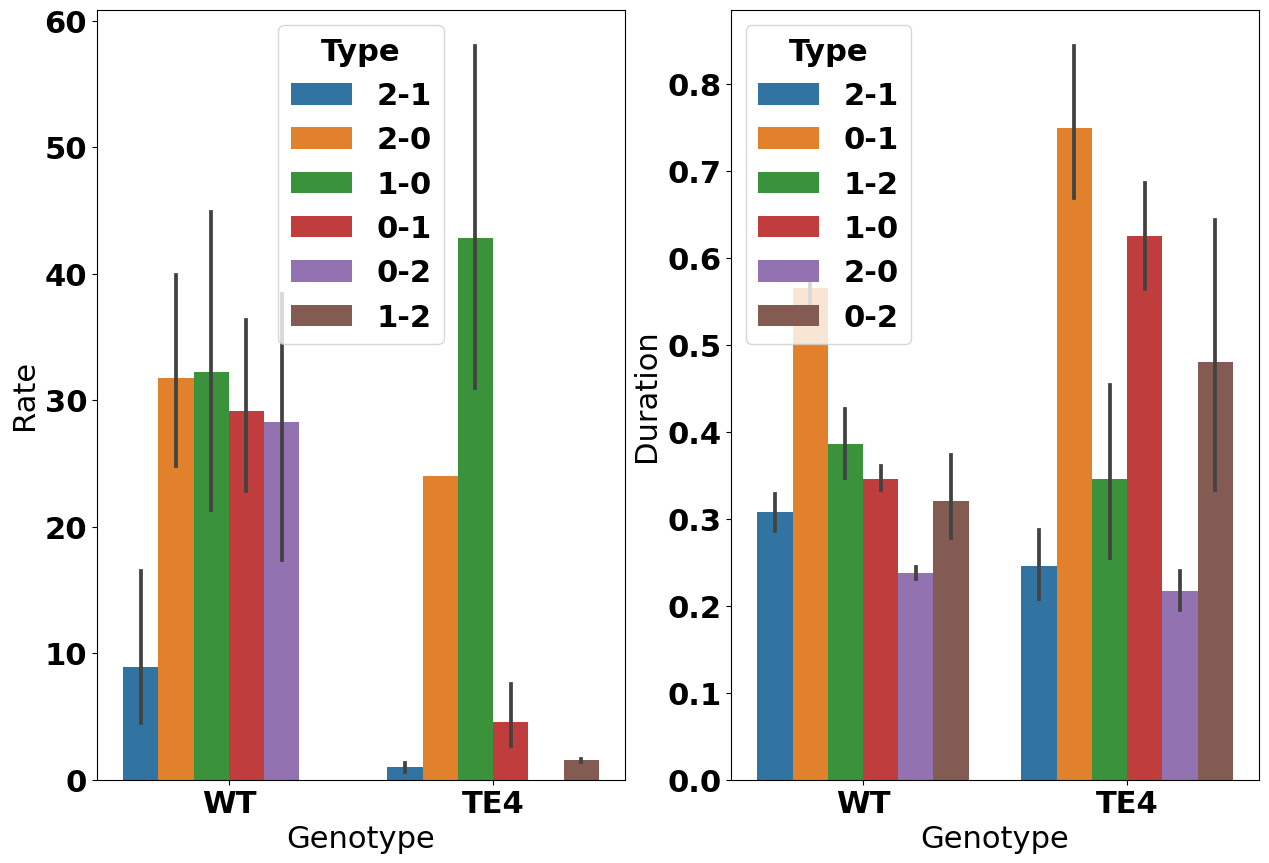

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15,10))

sns.barplot(
    data = all_bout_rates_geno[all_bout_rates_geno['Type'] != 'None'],
    x = 'Genotype',
    y = 'Rate',
    hue = 'Type',
    ax = axs[0]
)

sns.barplot(
    data = all_durations_geno[all_durations_geno['Type'] != 'None'],
    x = 'Genotype',
    y = 'Duration',
    hue = 'Type',
    ax = axs[1]
)

<Axes: xlabel='Animal', ylabel='Duration'>

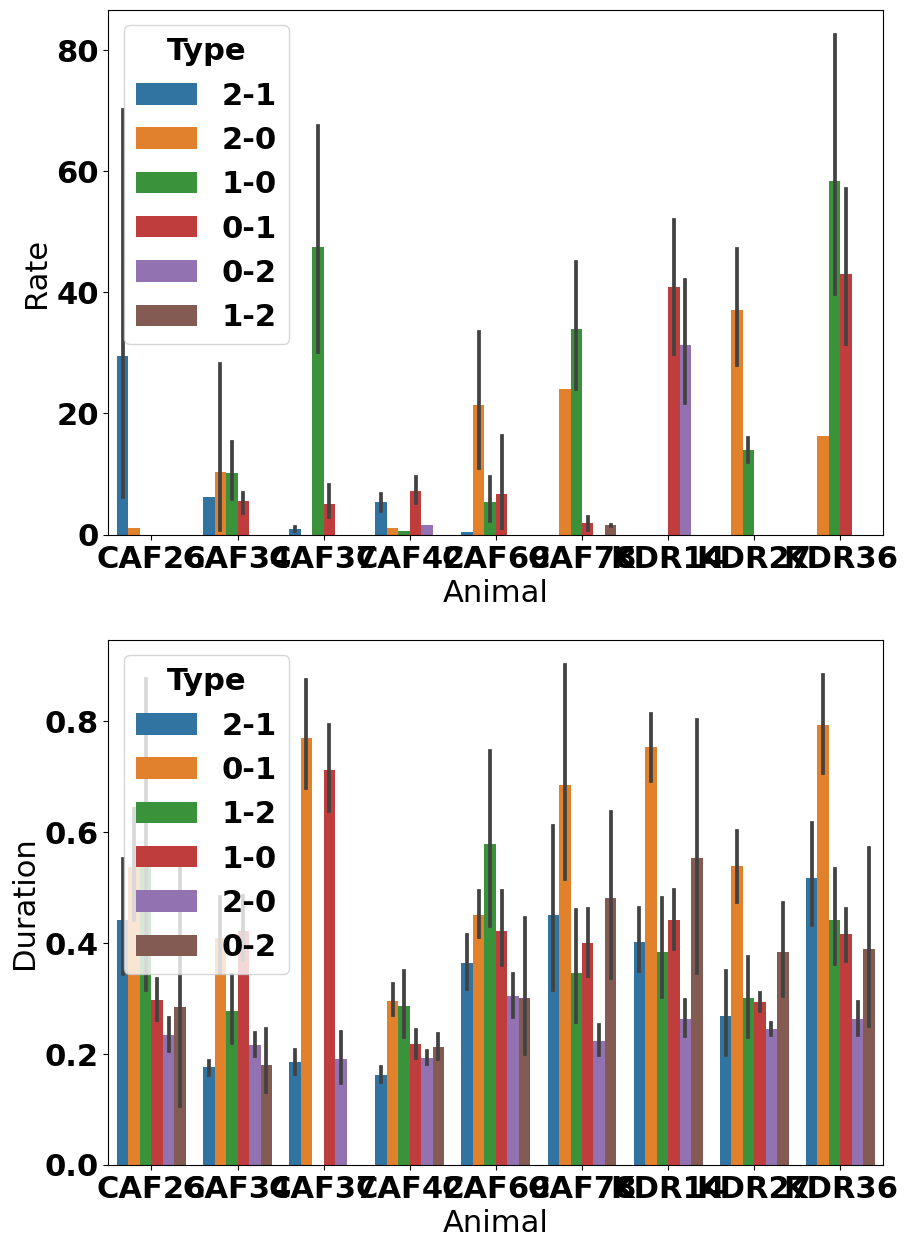

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(10,15))

sns.barplot(
    data = all_bout_rates_geno[all_bout_rates_geno['Type'] != 'None'].reset_index(),
    x = 'Animal',
    y = 'Rate',
    hue = 'Type',
    ax = axs[0]
)

sns.barplot(
    data = all_durations_geno[all_durations_geno['Type'] != 'None'].reset_index(),
    x = 'Animal',
    y = 'Duration',
    hue = 'Type',
    ax = axs[1]
)


In [23]:
for type in all_rates_geno.Type.unique():
    clip = all_rates_geno[all_rates_geno.Type == type]
    print(f'Testing {type}')
    print(
        stats.ranksums(
            clip[clip.Genotype == 'WT']['Count'],
            clip[clip.Genotype == 'TE4']['Count']
        )
    )

Testing None
RanksumsResult(statistic=6.5276210111780975, pvalue=6.682251582890017e-11)
Testing 0-1
RanksumsResult(statistic=3.8936686733343038, pvalue=9.873949013423838e-05)
Testing 0-2
RanksumsResult(statistic=7.844597180099995, pvalue=4.343454342352111e-15)
Testing 1-0
RanksumsResult(statistic=-5.210644842256201, pvalue=1.8818539542326336e-07)
Testing 1-2
RanksumsResult(statistic=6.584880844609485, pvalue=4.5525034370992805e-11)
Testing 2-0
RanksumsResult(statistic=10.478549517943788, pvalue=1.0839338186563257e-25)
Testing 2-1
RanksumsResult(statistic=5.210644842256201, pvalue=1.8818539542326336e-07)


In [24]:
td = stat_eval(compute_percent_by_bout)

Found channels: -0-64 in column: CA1-0-64-flicker-state
Found channels: -128-192 in column: CA1-128-192-flicker-state
Found channels: -192-256 in column: CA1-192-256-flicker-state
Found channels: -0-64 in column: CA1-0-64-flicker-state
Found channels: -0-64 in column: CA1-0-64-flicker-state
Found channels: -64-128 in column: CA1-64-128-flicker-state
Found channels: -0-64 in column: CA1-0-64-flicker-state
Found channels: -128-192 in column: CA1-128-192-flicker-state
Found channels: -0-64 in column: CA1-0-64-flicker-state


In [28]:
td = td.set_index('Animal').join(dm.agg('Animal')['Genotype'])
td.loc[td.Genotype.isna(), 'Genotype'] = 'WT'
#td.Type = td.Type.apply(decode)

KeyError: "None of ['Animal'] are in the columns"

> /hlabhome/wg-mjames/.conda/envs/tovi_dl/lib/python3.10/site-packages/pandas/core/frame.py(6012)set_index()
   6010 
   6011         if missing:
-> 6012             raise KeyError(f"None of {missing} are in the columns")
   6013 
   6014         if inplace:



In [30]:
def better_name(x):
    if x == 'None':
        return "None"
    
    mapping = {
        0 : 'Wake',
        1: 'NREM',
        2: "REM",
    }
    first = mapping[int(x[0])]
    last = mapping[int(x[-1])]
    return first+'-'+last

td.Type = td.Type.apply(better_name)

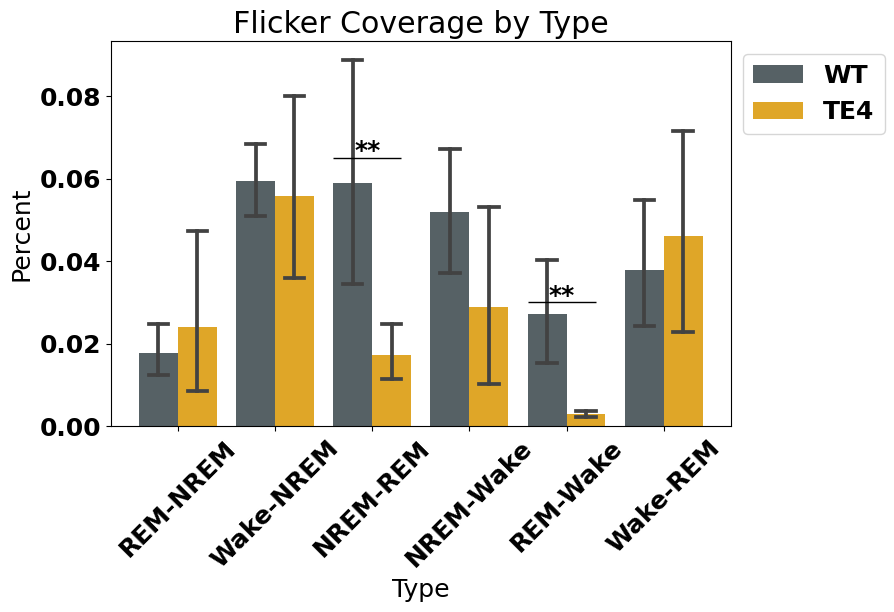

In [67]:
font = {
    'weight' : 'bold',
    'size'   : 18}
plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    data = td[td['Type'] != 'None'],
    x = 'Type',
    y = 'Percent',
    hue = 'Genotype',
    capsize=0.2,
    palette={'WT':sns.xkcd_rgb['gunmetal'], 'TE4':sns.xkcd_rgb['saffron']}
)

plt.hlines(0.065, 1.6, 2.3, colors='k', linestyles='solid', lw=1)
plt.text(1.95, 0.065, '**', ha='center')

plt.hlines(0.03, 3.6, 4.3, colors='k', linestyles='solid', lw=1)
plt.text(3.95, 0.03, '**', ha='center')


plt.legend(bbox_to_anchor=(1, 1))
plt.gca().set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title('Flicker Coverage by Type')

plt.savefig('./figures_new/flicker_coverage.pdf', format='pdf')

In [ ]:
for type in td.Type.unique():
    clip = td[td.Type == type]
    print(f'Testing {type}')
    print(
        stats.ranksums(
            clip[clip.Genotype == 'WT']['Percent'],
            clip[clip.Genotype == 'TE4']['Percent']
        )
    )

Testing None
RanksumsResult(statistic=-10.829503050774113, pvalue=2.495057145321331e-27)
Testing REM-NREM
RanksumsResult(statistic=0.3097867050847094, pvalue=0.7567231624135761)
Testing Wake-NREM
RanksumsResult(statistic=0.3738153838986498, pvalue=0.7085416732267715)
Testing NREM-REM
RanksumsResult(statistic=-2.5154548068381617, pvalue=0.01188789173156575)
Testing NREM-Wake
RanksumsResult(statistic=2.1844058615477935, pvalue=0.028932437892557727)
Testing REM-Wake
RanksumsResult(statistic=5.102375136572148, pvalue=3.354170438468678e-07)
Testing Wake-REM
RanksumsResult(statistic=-1.7176197847465275, pvalue=0.08586598918123785)


In [44]:
td

,Type,Percent,Genotype
Animal,,,
CAF26,None,0.995240,WT
CAF26,REM-NREM,0.004760,WT
CAF26,None,1.000000,WT
CAF26,None,0.994333,WT
CAF26,Wake-NREM,0.005000,WT
...,...,...,...
KDR36,NREM-Wake,0.018638,WT
KDR36,NREM-Wake,1.000000,WT
KDR36,NREM-Wake,0.000229,WT


In [47]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

t = td[td.Type != 'None'].reset_index()

model = smf.mixedlm(
    "Percent ~ Type + Genotype", 
    t, 
    groups=t["Animal"])
result = model.fit()
print(result.summary())

/hlabhome/wg-mjames/.conda/envs/tovi_dl/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/hlabhome/wg-mjames/.conda/envs/tovi_dl/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  Percent  
No. Observations:    3752     Method:              REML     
No. Groups:          9        Scale:               0.0183   
Min. group size:     120      Log-Likelihood:      2144.2965
Max. group size:     787      Converged:           Yes      
Mean group size:     416.9                                  
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.048    0.022  2.170 0.030  0.005  0.092
Type[T.NREM-Wake] -0.012    0.010 -1.257 0.209 -0.032  0.007
Type[T.REM-NREM]  -0.034    0.010 -3.434 0.001 -0.053 -0.014
Type[T.REM-Wake]  -0.033    0.010 -3.216 0.001 -0.053 -0.013
Type[T.Wake-NREM] -0.000    0.010 -0.025 0.980 -0.019  0.018
Type[T.Wake-REM]  -0.019    0.012 -1.589 0.112 -0.042  0.004
Genotype[T.WT]    -0.002    0.023 -0

/hlabhome/wg-mjames/.conda/envs/tovi_dl/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
